In [28]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt

sys.path.append('..')
file_path = '../data/processed/notebooks/master_analytical_file.parquet'

if os.path.exists(file_path):
    df_master = pd.read_parquet(file_path)
    print(f"Loaded Master Data: {len(df_master):,} rows")
    print(f"Date range: {df_master['shipped_dt'].min()} to {df_master['shipped_dt'].max()}")
else:
    print("Error: Master file not found. Please run Notebook 02 first.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded Master Data: 1,983,549 rows
Date range: 2025-01-01 00:00:00.275000 to 2025-12-31 21:40:11


In [29]:
snapshot_date = df_master['shipped_dt'].max() + dt.timedelta(days=1)

rfm = df_master.groupby('trade_account_id').agg({
    'shipped_dt': lambda x: (snapshot_date - x.max()).days, # Recency
    'order_id': 'nunique',                                  # Frequency
    'netrevenue': 'sum'                                     # Monetary
}).reset_index()

rfm.columns = ['trade_account_id', 'Recency', 'Frequency', 'Monetary']

samples_count = df_master[df_master['type'] == 'SAMPLE'].groupby('trade_account_id').size().reset_index()
samples_count.columns = ['trade_account_id', 'Sample_Count']

rfm = rfm.merge(samples_count, on='trade_account_id', how='left').fillna(0)

print(rfm.head())

   trade_account_id  Recency  Frequency  Monetary  Sample_Count
0            626163      240          1       0.0           3.0
1            626165      230          5    2750.0          23.0
2            626181      101          7       0.0          38.0
3            626194      156          5     962.0          28.0
4            626202        8        178   13947.5        1376.0


In [30]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
rfm['RFM_Cell'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_25920\3988810126.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




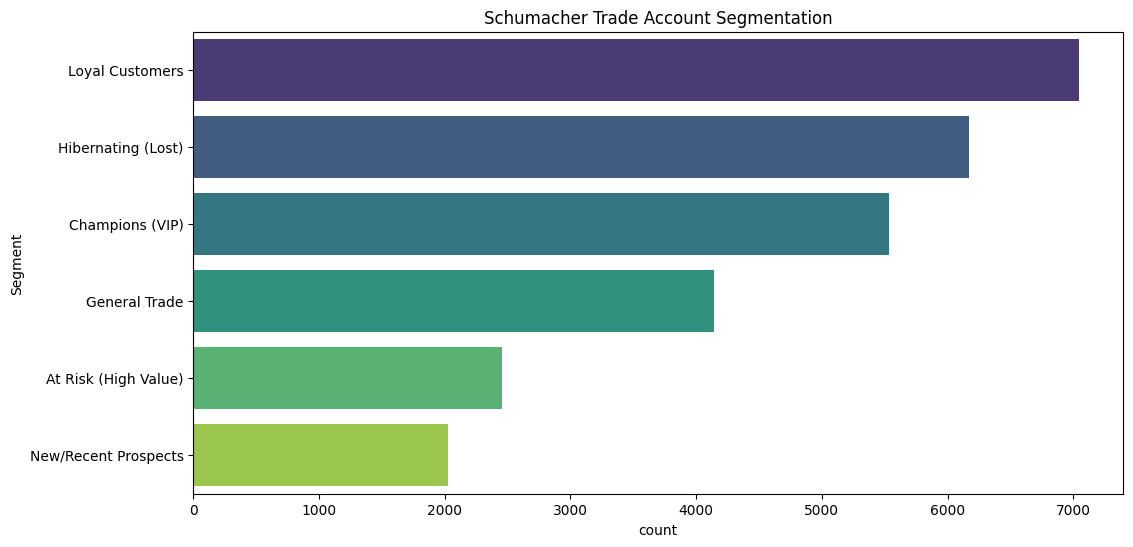

In [31]:
def segment_me(df):
    r = int(df['R_Score'])
    f = int(df['F_Score'])
    m = int(df['M_Score'])
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions (VIP)'
    elif r >= 3 and f >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'New/Recent Prospects'
    elif r <= 2 and m >= 4:
        return 'At Risk (High Value)'
    elif r <= 2 and f <= 2:
        return 'Hibernating (Lost)'
    else:
        return 'General Trade'

rfm['Segment'] = rfm.apply(segment_me, axis=1)

plt.figure(figsize=(12, 6))
sns.countplot(data=rfm, y='Segment', palette='viridis', order=rfm['Segment'].value_counts().index)
plt.title('Schumacher Trade Account Segmentation')
plt.show()

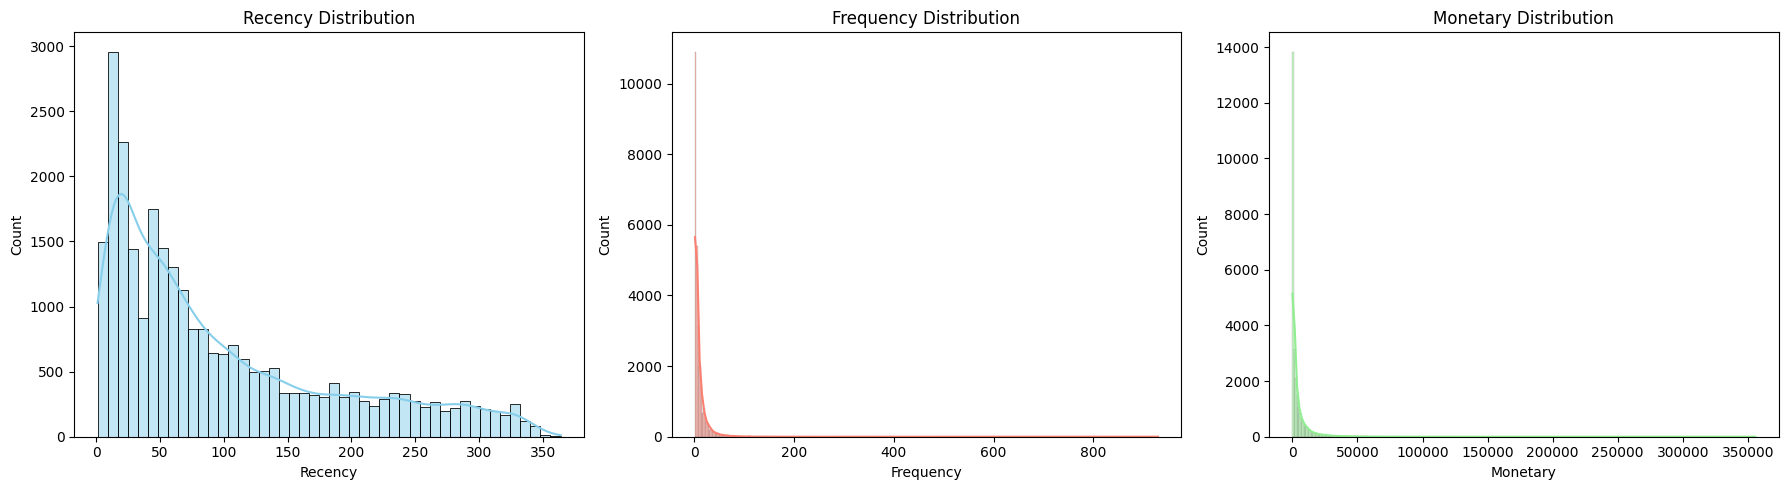

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], kde=True, ax=axes[0], color='skyblue').set_title('Recency Distribution')
sns.histplot(rfm['Frequency'], kde=True, ax=axes[1], color='salmon').set_title('Frequency Distribution')
sns.histplot(rfm['Monetary'], kde=True, ax=axes[2], color='lightgreen').set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

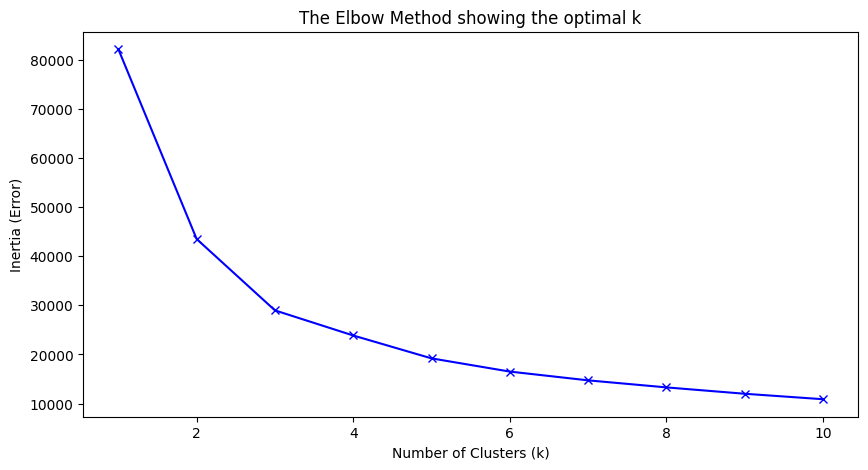

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

features = ['Recency', 'Frequency', 'Monetary']
date_to_scale = rfm[features]

data_log = np.log(date_to_scale + 1)

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(data_log)

inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Error)')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_transform(rfm_scaled).argmax(axis=1) # Simplified assignment

# Calculate Cluster Profiles
cluster_profile = rfm.groupby('Cluster')[features].mean().round(2)
cluster_profile['Count'] = rfm.groupby('Cluster').size()
print(cluster_profile.sort_values('Monetary', ascending=False))

         Recency  Frequency  Monetary  Count
Cluster                                     
1          35.78      17.59   8259.91  12030
3         160.00       6.28   4253.64   2000
2         149.22       2.66    399.36  12882
0          13.86       8.15      0.00    462


In [35]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=rfm['Recency'],
    y=rfm['Frequency'],
    z=rfm['Monetary'],
    mode='markers',
    marker=dict(
        size=3,
        color=rfm['Cluster'], 
        colorscale='Viridis',
        opacity=0.6
    )
)])

fig.update_layout(
    title='3D Customer Segmentation: The Schumacher Designer Ecosystem',
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary (USD)'
    )
)
fig.show()

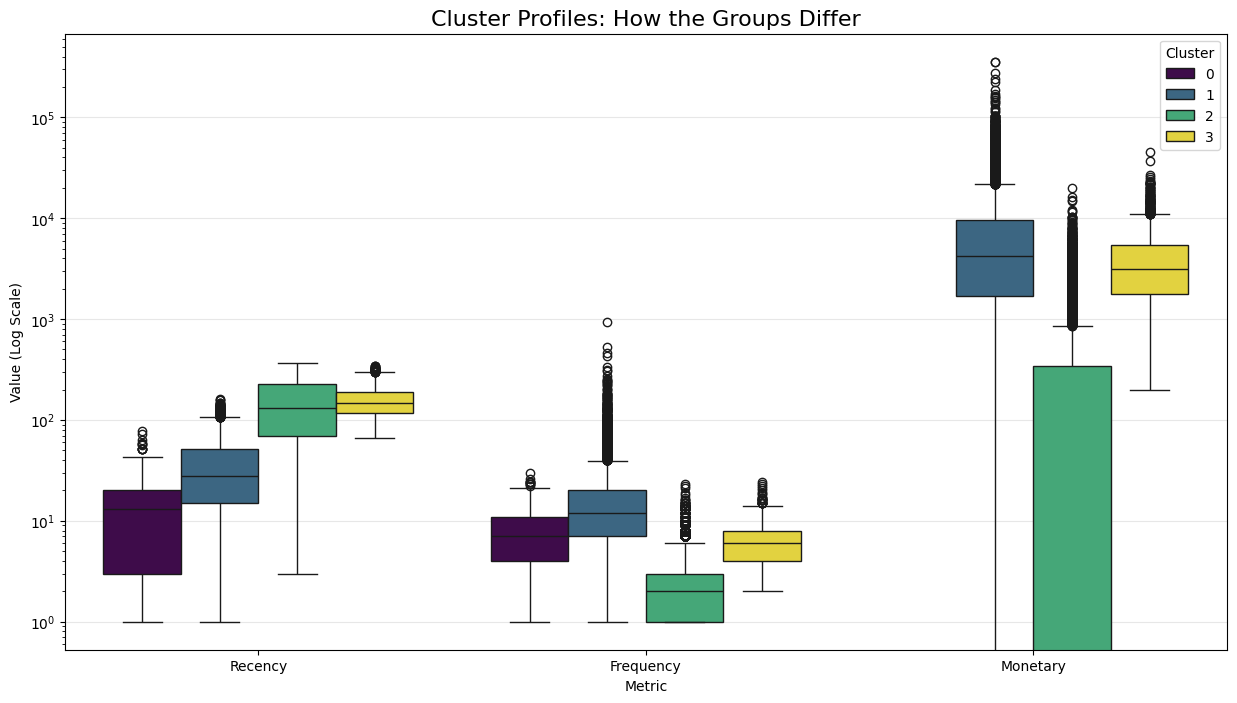

In [36]:
rfm_melted = rfm.melt(id_vars=['Cluster'], 
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                    var_name='Metric', value_name='Value')

plt.figure(figsize=(15, 8))
sns.boxplot(x='Metric', y='Value', hue='Cluster', data=rfm_melted, palette='viridis')
plt.yscale('log')
plt.title('Cluster Profiles: How the Groups Differ', fontsize=16)
plt.ylabel('Value (Log Scale)')
plt.grid(axis='y', alpha=0.3)
plt.show()

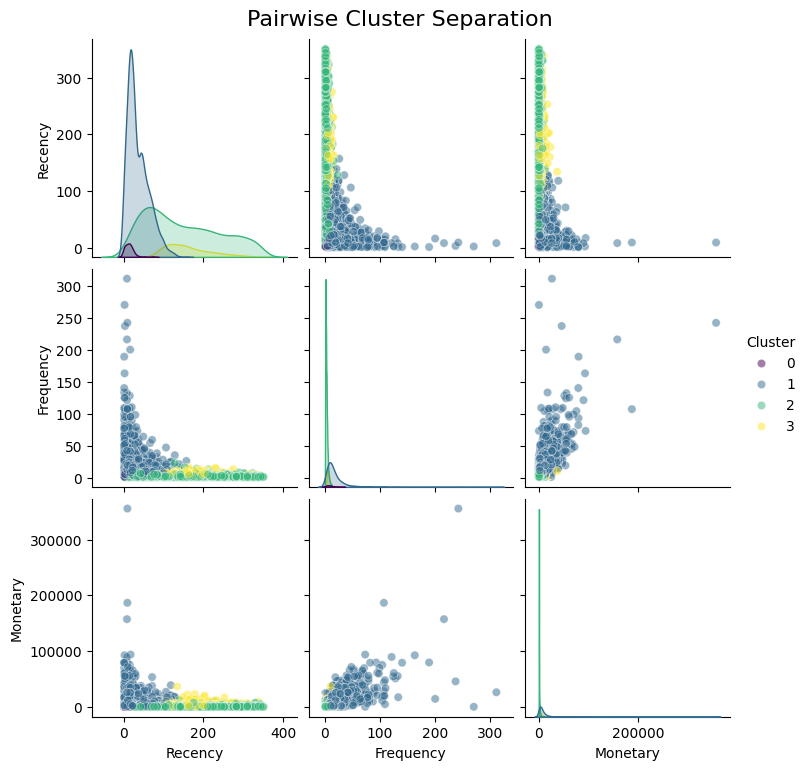

In [37]:
sns.pairplot(rfm.sample(5000), vars=['Recency', 'Frequency', 'Monetary'], 
            hue='Cluster', palette='viridis', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Cluster Separation', y=1.02, fontsize=16)
plt.show()

In [38]:
profile = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
profile['Recency'] = profile['Recency'].max() - profile['Recency'] 

scaler = MinMaxScaler()
profile_scaled = pd.DataFrame(scaler.fit_transform(profile), columns=profile.columns, index=profile.index)

import plotly.graph_objects as go

fig = go.Figure()

for i in profile_scaled.index:
    fig.add_trace(go.Scatterpolar(
        r=profile_scaled.loc[i].values,
        theta=profile_scaled.columns,
        fill='toself',
        name=f'Cluster {i}'
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=True,
    title="Cluster DNA: Relative RFM Strengths"
)
fig.show()

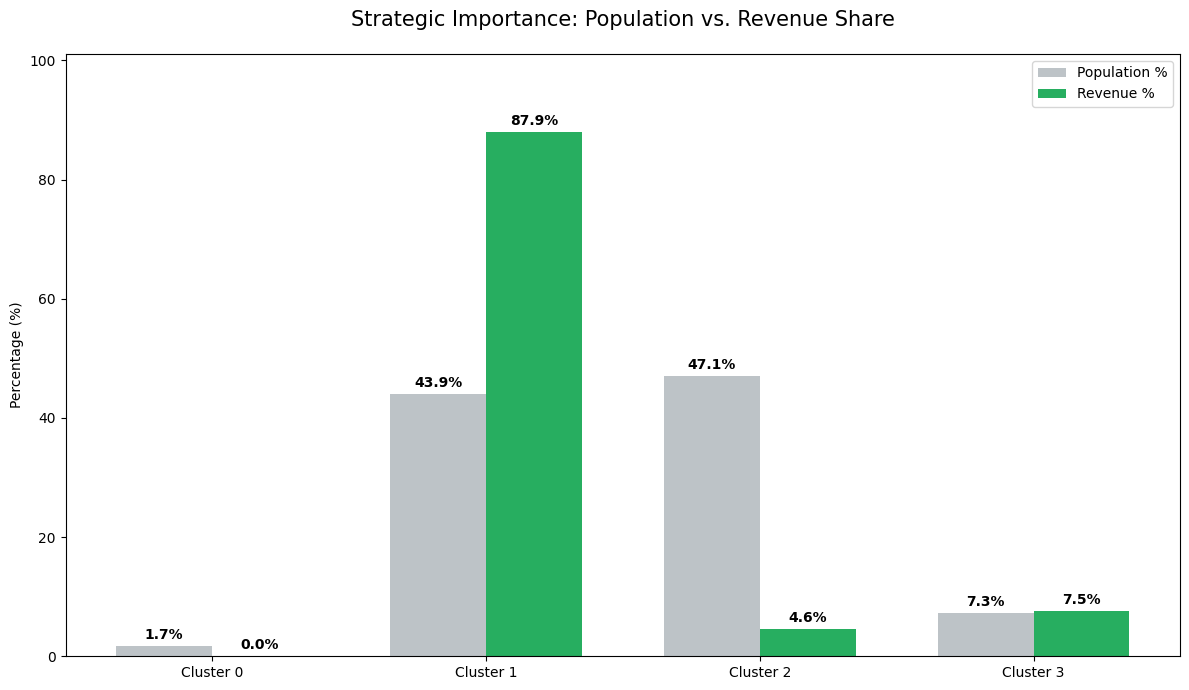

In [40]:
cluster_stats = rfm.groupby('Cluster').agg({
    'trade_account_id': 'count',
    'Monetary': 'sum'
}).reset_index()

cluster_stats['Revenue_Share'] = (cluster_stats['Monetary'] / cluster_stats['Monetary'].sum()) * 100
cluster_stats['Population_Share'] = (cluster_stats['trade_account_id'] / cluster_stats['trade_account_id'].sum()) * 100
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(cluster_stats))
width = 0.35

rects1 = ax.bar(x - width/2, cluster_stats['Population_Share'], width, label='Population %', color='#BDC3C7')
rects2 = ax.bar(x + width/2, cluster_stats['Revenue_Share'], width, label='Revenue %', color='#27AE60')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', 
                    fontweight='bold', fontsize=10)

autolabel(rects1)
autolabel(rects2)

ax.set_xticks(x)
ax.set_xticklabels([f'Cluster {i}' for i in cluster_stats.index])
ax.set_title('Strategic Importance: Population vs. Revenue Share', fontsize=15, pad=20)
ax.set_ylabel('Percentage (%)')
ax.legend()
ax.set_ylim(0, max(cluster_stats['Revenue_Share'].max(), cluster_stats['Population_Share'].max()) * 1.15)

plt.tight_layout()
plt.show()

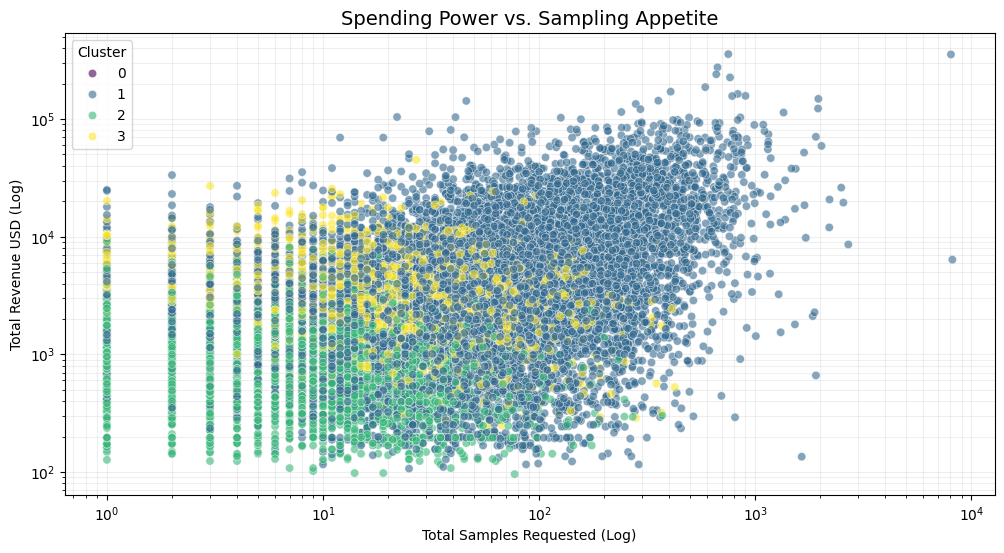

In [41]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm, x='Sample_Count', y='Monetary', hue='Cluster', palette='viridis', alpha=0.6)
plt.xscale('log')
plt.yscale('log')

plt.title('Spending Power vs. Sampling Appetite', fontsize=14)
plt.xlabel('Total Samples Requested (Log)')
plt.ylabel('Total Revenue USD (Log)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [ ]:
df_master = df_master.merge(
    rfm[['trade_account_id', 'Sample_Count', 'Cluster', 'Recency', 'Frequency']], 
    on='trade_account_id', 
    how='left'
)
output_path = '../data/processed/notebooks/final_analytics_data.parquet'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_master.to_parquet(output_path, index=False)
print(f"✅ Final Analytics Data (with Clusters) saved to: {output_path}")

✅ Final Analytics Data (with Clusters) saved to: ../data/processed/notebooks/final_analytics_data.parquet
